<!--NOTEBOOK_HEADER-->
*This notebook contains material from [ND-Pyomo-Cookbook](https://jckantor.github.io/ND-Pyomo-Cookbook);
content is available [on Github](https://github.com/jckantor/ND-Pyomo-Cookbook.git).*
*The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode),
and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<!--NAVIGATION-->
< [2.0 Linear Programming](https://jckantor.github.io/ND-Pyomo-Cookbook/02.00-Linear-Programming.html) | [Contents](toc.html) | [Tag Index](tag_index.html) | [2.2 Production Model Sensitivity Analysis](https://jckantor.github.io/ND-Pyomo-Cookbook/02.02-Production-Model-Sensitivity-Analysis.html) ><p><a href="https://colab.research.google.com/github/jckantor/ND-Pyomo-Cookbook/blob/master/docs/02.01-Production-Models-with-Linear-Constraints.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/ND-Pyomo-Cookbook/02.01-Production-Models-with-Linear-Constraints.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 2.1 Production Models with Linear Constraints

Keywords: linear programming, cbc usage, production models

This notebook demonstrates the use of linear programming to maximize profit for a simple model of a multiproduct production facility. The notebook uses [Pyomo](http://www.pyomo.org/) to represent the model with the [COINOR-CBC](https://github.com/coin-or/Cbc) solver to calculate solutions.

## 2.1.1 Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
    else:
        try:
            !conda install -c conda-forge coincbc 
        except:
            pass

assert(shutil.which("cbc") or os.path.isfile("cbc"))

from pyomo.environ import *

## 2.1.2 Example: Production plan for a single product plant

Suppose you are thinking about starting up a business to produce Product X. You have determined there is a market for X of up to 40 units per week at a price of USD 270 each. The production of each unit requires USD 100 of raw materials, 1 hour of type A labor, and 2 hours of type B labor. You have an unlimited amount of raw material available to you, but only 80 hours per week of labor A at a cost of USD 50/hour, and 100 hours per week of labor B at a cost of USD 40 per hour. Ignoring all other expenses, what is the maximum weekly profit?

To get started on this problem, we sketch a flow diagram illustrating the flow of raw materials and labor through the production plant.

![LP_ProductX.png](https://github.com/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/figures/LP_ProductX.png?raw=1)

The essential decision we need to make is how many units or Product X to produce each week. That's our *decision variable* which we denote as $x$. The weekly revenues are then

$$ \mbox{Revenue} = \$270 x $$

The costs include the value of the raw materials and each form of labor. If we produce x units a week, then the total cost is

$$ \mbox{Cost} = \underbrace{\$100 x}_{\mbox{Raw Material}} 
    + \underbrace{\$50 x}_{\mbox{Labor A}} + \underbrace{2\times\$40 x}_{\mbox{Labor B}} = \$230 x$$
    
We see immediately that the gross profit is just

$$\begin{eqnarray*}\mbox{Profit} & = & \mbox{Revenue} - \mbox{Cost} \\
& = & \$270x - \$230x \\
& = & \$40 x
\end{eqnarray*}$$

which means there is a profit earned on each unit of X produced, so let's produce as many as possible. 

There are three constraints that limit how many units can be produced. There is market demand for no more than 40 units per week. Producing $x = 40$ units per week will require 40 hours per week of Labor A, and 80 hours per week of Labor B. Checking those constraints we see that we have enough labor of each type, so the maximum profit will be

$$\max \mbox{Profit} = $40 \mbox{ per unit} \times 40 \mbox{ units per week} = \$1600 \mbox{ per week}$$

What we conclude is that market demand is the 'most constraining constraint.' Once we've made that deduction, the rest is a straightforward problem that can be solved by inspection.  

### 2.1.2.1 Pyomo model

While this problem can be solved by inspection, here we show a Pyomo model that generates a solution to the problem.

In [2]:
model = ConcreteModel()

# declare decision variables
model.x = Var(domain=NonNegativeReals)

# declare objective
model.profit = Objective(
    expr = 40*model.x,
    sense = maximize)

# declare constraints
model.demand = Constraint(expr = model.x <= 40)
model.laborA = Constraint(expr = model.x <= 80)
model.laborB = Constraint(expr = 2*model.x <= 100)

# solve
SolverFactory('cbc').solve(model).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 1600.0
  Upper bound: 1600.0
  Number of objectives: 1
  Number of constraints: 4
  Number of variables: 2
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.01
  Wallclock time: 0.0
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: None
      Number of created 

The results of the solution step show the solver has converged to an optimal solution. Next we display the particular components of the model of interest to us.

In [3]:
print("Profit = ", model.profit(), " per week")
print("X = ", model.x(), " units per week")

Profit =  1600.0  per week
X =  40.0  units per week


### 2.1.2.2 Exercises

1. Suppose the demand could be increased to 50 units per month. What would be the increased profits?  What if the demand increased to 60 units per month?  How much would you be willing to pay for your marketing department for the increased demand?

2. Increase the cost of LaborB. At what point is it no longer financially viable to run the plant?

## 2.1.3 Production plan: Product Y

Your marketing department has developed plans for a new product called Y. The product sells at a price of USD 210/each, and they expect that you can sell all that you can make. It's also cheaper to make, requiring only USD 90 in raw materials, 1 hour of Labor type A at USD 50 per hour, and 1 hour of Labor B at USD 40 per hour. What is the potential weekly profit?

![LP_ProductY.png](https://github.com/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/figures/LP_ProductY.png?raw=1)

In [4]:
model = ConcreteModel()

# declare decision variables
model.y = Var(domain=NonNegativeReals)

# declare objective
model.profit = Objective(
    expr = 30*model.y,
    sense = maximize)

# declare constraints
model.laborA = Constraint(expr = model.y <= 80)
model.laborB = Constraint(expr = model.y <= 100)

# solve
SolverFactory('cbc').solve(model).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 2400.0
  Upper bound: 2400.0
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 2
  Number of nonzeros: 0
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.01
  Wallclock time: 0.0
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: None
      Number of created 

In [5]:
print("Profit = ", model.profit())
print("Units of Y = ", model.y())

Profit =  2400.0
Units of Y =  80.0


Compared to product X, we can manufacture and sell up 80 units per week for a total profit of \$2,400. This is very welcome news. 

### 2.1.3.1 Exercises

1. What is the limiting resource?  That is, which of the two types of labor limits the capacity of your plant to produce more units of Y?

2. What rate would you be willing to pay for the additional labor necessary to increase the production of Y?

## 2.1.4 Production plan: Mixed product strategy

So far we have learned that we can make \$1,600 per week by manufacturing product X, and $2,400 per week manufacturing product Y.  Is it possible to do even better?

To answer this question, we consider the possibilty of manufacturing both products in the same plant. The marketing department assures us that product Y will not affect the sales of product X.  So the same constraints hold as before, but now we have two decision variables, $x$ and $y$.

![LP_ProductXY.png](https://github.com/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/figures/LP_ProductXY.png?raw=1)

In [6]:
model = ConcreteModel()

# declare decision variables
model.x = Var(domain=NonNegativeReals)
model.y = Var(domain=NonNegativeReals)

# declare objective
model.profit = Objective(
    expr = 40*model.x + 30*model.y,
    sense = maximize)

# declare constraints
model.demand = Constraint(expr = model.x <= 40)
model.laborA = Constraint(expr = model.x + model.y <= 80)
model.laborB = Constraint(expr = 2*model.x + model.y <= 100)

# solve
SolverFactory('cbc').solve(model).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 2600.0
  Upper bound: 2600.0
  Number of objectives: 1
  Number of constraints: 4
  Number of variables: 3
  Number of nonzeros: 2
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.01
  Wallclock time: 0.0
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: None
      Number of created 

In [7]:
# display solution
print("Profit = ", model.profit())
print("Units of X = ", model.x())
print("Units of Y = ", model.y())

Profit =  2600.0
Units of X =  20.0
Units of Y =  60.0


The mixed product strategy earns more profit than either of the single product srategies. Does this surprise you?  Before going further, try to explain why it is possible for a mixed product strategy to earn more profit than either of the possible single product strategies.

## 2.1.5 What are the active constraints?

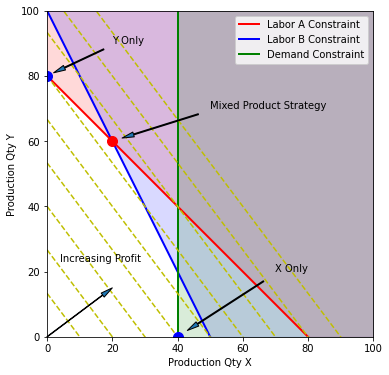

In [8]:
plt.figure(figsize=(6, 6))
plt.subplot(111, aspect='equal')
plt.axis([0, 100, 0, 100])
plt.xlabel('Production Qty X')
plt.ylabel('Production Qty Y')

# Labor A constraint
x = np.array([0, 80])
y = 80 - x
plt.plot(x, y, 'r', lw=2)
plt.fill_between([0, 80, 100], [80, 0,0 ], [100, 100, 100], color='r', alpha=0.15)

# Labor B constraint
x = np.array([0, 50])
y = 100 - 2*x
plt.plot(x, y, 'b', lw=2)
plt.fill_between([0, 50, 100], [100, 0, 0], [100, 100, 100], color='b', alpha=0.15)

# Demand constraint
plt.plot([40, 40], [0, 100], 'g', lw=2)
plt.fill_between([40, 100], [0, 0], [100, 100], color='g', alpha=0.15)

plt.legend(['Labor A Constraint', 'Labor B Constraint', 'Demand Constraint'])

# Contours of constant profit
x = np.array([0, 100])
for p in np.linspace(0, 3600, 10):
    y = (p - 40*x)/30
    plt.plot(x, y, 'y--')

# Optimum
plt.plot(20, 60, 'r.', ms=20)
plt.annotate('Mixed Product Strategy', xy=(20, 60), xytext=(50, 70), 
             arrowprops=dict(shrink=.1, width=1, headwidth=5))

plt.plot(0, 80, 'b.', ms=20)
plt.annotate('Y Only', xy=(0, 80), xytext=(20, 90), 
             arrowprops=dict(shrink=0.1, width=1, headwidth=5))

plt.plot(40, 0, 'b.', ms=20)
plt.annotate('X Only', xy=(40, 0), xytext=(70, 20), 
             arrowprops=dict(shrink=0.1, width=1, headwidth=5))

plt.text(4, 23, 'Increasing Profit')
plt.annotate('', xy=(20,15), xytext=(0,0), 
             arrowprops=dict(width=0.5,headwidth=5))

fname = 'LPprog01.png'
fname = os.path.join('figures', fname) if os.path.exists('figures') else fname
plt.savefig(fname, bbox_inches='tight')

<!--NAVIGATION-->
< [2.0 Linear Programming](https://jckantor.github.io/ND-Pyomo-Cookbook/02.00-Linear-Programming.html) | [Contents](toc.html) | [Tag Index](tag_index.html) | [2.2 Production Model Sensitivity Analysis](https://jckantor.github.io/ND-Pyomo-Cookbook/02.02-Production-Model-Sensitivity-Analysis.html) ><p><a href="https://colab.research.google.com/github/jckantor/ND-Pyomo-Cookbook/blob/master/docs/02.01-Production-Models-with-Linear-Constraints.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/ND-Pyomo-Cookbook/02.01-Production-Models-with-Linear-Constraints.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>